# The 2-site frequency spectrum of 200 genes in 1,000 European samples

The goal of this notebook is to calculate the 1- and 2-site frequency spectrum from the Nelson et al. dataset, which includes ~1K European samples sequenced to high coverage at ~200 genes. We're doing this because it is one of two data sets used as examples by the fastNeutrino paper. The next step will be to use msprime to calculate the 2-site frequency spectrum in msprime simulations of the best-fit fastNeutrino demographic model.

Here we will:
- Apply the coverage filters to the variants in the variant file (S2).
- Calculate the gene-by-gene SFS for four-fold degenerate sites and compare to those reported in file S3. (This is purely a sanity check. We're not interested in gene-by-gene SFS.)
- Calculate the overall 1- and 2-site frequency spectra across genes. We will coarse-grain the 2-SFS into high- and low-frequency snps.
- Test the sensitivity of the 2-site frequency spectrum to:
    - The cutoff frequency between high and low frequency
    - The cutoff distance between snps for inclusion in the 2-site frequency spectrum.

## Importing the data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [12]:
targets = pd.read_table('../data/NelsonEtal/S1_targets.txt')
targets.head()

,Gene,Gene37,Chromosome,Exon.NCBI.36.Start,Exon.NCBI.36.Stop,Exon.plus.50.bp.flanking.sequence.NCBI.36.Start,Exon.plus.50.bp.flanking.sequence.NCBI.36.Stop,Entrez.Gene.ID,Transcript,Ensembl.Gene.ID,...,intron,upstream,downstream,code.cover,utr.cover,intron.cover,upstream.cover,downstream.cover,TargetLength,CoverLength
0,ABCB1,ABCB1,7,86970884,86971701,86970834,86971751,5243,NM_000927,ENSG00000085563,...,50,0,50,207,611,50,0,50,918,918
1,ABCB1,ABCB1,7,86973149,86973295,86973099,86973345,5243,NM_000927,ENSG00000085563,...,100,0,0,147,0,100,0,0,247,247
2,ABCB1,ABCB1,7,86976527,86976733,86976477,86976783,5243,NM_000927,ENSG00000085563,...,100,0,0,207,0,100,0,0,307,307
3,ABCB1,ABCB1,7,86982483,86982680,86982433,86982730,5243,NM_000927,ENSG00000085563,...,100,0,0,198,0,100,0,0,298,298
4,ABCB1,ABCB1,7,86983761,86983917,86983711,86983967,5243,NM_000927,ENSG00000085563,...,100,0,0,157,0,100,0,0,257,257


In [17]:
targets[['code', 'code.cover']].describe()

,code,code.cover
count,1989.000000,1989.000000
mean,176.598291,167.959779
std,249.279071,243.721186
min,0.000000,0.000000
25%,84.000000,80.000000
50%,128.000000,125.000000
75%,185.000000,177.000000
max,4795.000000,4795.000000


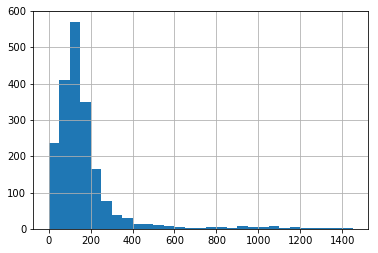

In [35]:
targets['code'].hist(bins=np.arange(0,1500,50))

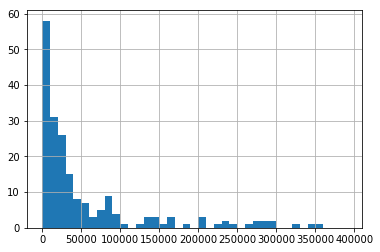

In [32]:
grouped = targets.groupby('Gene')
gene_lengths = grouped['Exon.NCBI.36.Start'].max() - grouped['Exon.NCBI.36.Start'].min()
gene_lengths.describe()
gene_lengths.hist(bins=np.arange(0,4e5,10000))

Import variant data.

In [90]:
columns = ['CHROMOSOME','POSITION','GENE','FEATURE','AA1','AA2','Eur.MA_COUNT','Eur.NOBS','Eur.FREQ']
variants = pd.read_table('../data/NelsonEtal/S2_variants.txt', usecols=columns)

/Users/dpr/miniconda3/envs/mmc_py35/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2698: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Not sure which columns are giving this error.

We only want variants that are (1) segregating in the european sample, and (2) sufficiently well-covered.

In [92]:
n_cutoff = 11000
variants = variants[(variants['Eur.MA_COUNT']>0) & (variants['Eur.NOBS']>=2*n_cutoff)]

We're going to want to focus (at least in part) on 4-fold degenerate sites.

In [103]:
degenerate_aas = list('AGPVT')
print(degenerate_aas)

['A', 'G', 'P', 'V', 'T']


In [104]:
degenerate_vars = variants[(variants['FEATURE'] == 'Synonymous') & (variants['AA1'].isin(degenerate_aas))]

In [138]:
variants.groupby('FEATURE').agg('count')

,CHROMOSOME,POSITION,GENE,AA1,AA2,Eur.MA_COUNT,Eur.NOBS,Eur.FREQ
FEATURE,,,,,,,,
Downstream,162,162,162,0,0,162,162,162
ESSENTIAL_SPLICE_SITE,20,20,20,20,20,20,20,20
Intron,7474,7474,7474,125,56,7474,7474,7474
NonSynonymous,8585,8585,8585,8585,8585,8585,8585,8585
Nonsense,233,233,233,233,233,233,233,233
Readthrough,9,9,9,9,9,9,9,9
SPLICE_SITE,249,249,249,249,249,249,249,249
Synonymous,5412,5412,5412,5412,5412,5412,5412,5412
UTR,12406,12406,12406,39,22,12406,12406,12406


In [105]:

degenerate_vars.shape

(2165, 9)

## Allele frequency spectra

Compare the sfs for 4-fold degenerate, all synonymous, and non-synonymous mutations:

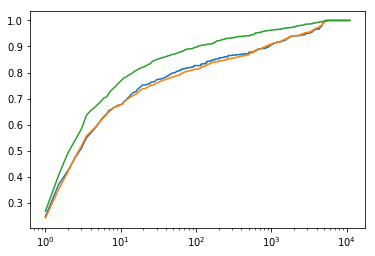

In [135]:
x = np.arange(1,n_cutoff+1,0.5)
sfs_syn = np.histogram(variants[variants['FEATURE']=='Synonymous']['Eur.FREQ'],bins=x/n_cutoff)[0]
sfs_non = np.histogram(variants[variants['FEATURE']=='NonSynonymous']['Eur.FREQ'],bins=x/n_cutoff)[0]
sfs_4d = np.histogram(degenerate_vars['Eur.FREQ'],bins=x/n_cutoff)[0]
plt.semilogx(x[:-1], np.cumsum(sfs_4d)/np.sum(sfs_4d))
plt.semilogx(x[:-1], np.cumsum(sfs_syn)/np.sum(sfs_syn))
plt.semilogx(x[:-1], np.cumsum(sfs_non)/np.sum(sfs_non))

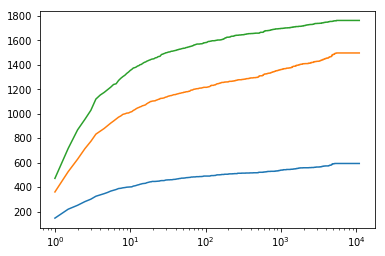

In [191]:
plt.semilogx(x[:-1], np.cumsum(sfs_4d))
plt.semilogx(x[:-1], np.cumsum(sfs_syn))
plt.semilogx(x[:-1], np.cumsum(sfs_non))

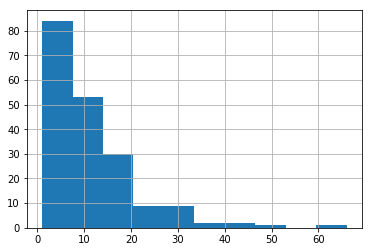

In [148]:
degenerate_vars.groupby('GENE').size().hist()

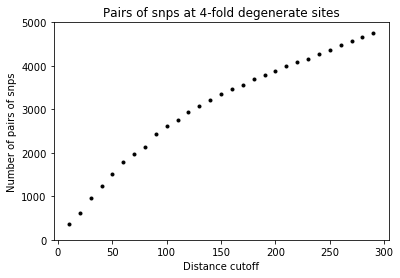

In [196]:
grouped = degenerate_vars.groupby('GENE')
for d_cutoff in np.arange(10,300,10):
    n_comps = 0
    for g, muts in grouped:
        #muts = grouped.get_group(g)
        pos = muts['POSITION']
        p_diff = np.abs(pos[:,None]-pos[None,:])
        n_comps += np.sum((p_diff>0) & (p_diff<=d_cutoff))
    plt.plot(d_cutoff, n_comps, '.k')
plt.ylim([0,5000])
plt.xlabel('Distance cutoff')
plt.ylabel('Number of pairs of snps')
plt.title('Pairs of snps at 4-fold degenerate sites')

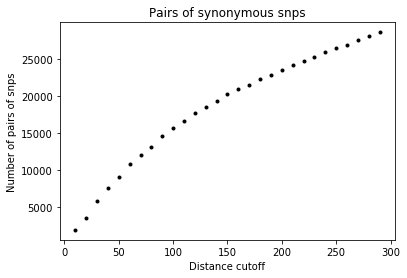

In [198]:
grouped = variants[variants['FEATURE']=='Synonymous'].groupby('GENE')
for d_cutoff in np.arange(10,300,10):
    n_comps = 0
    for g, muts in grouped:
        #muts = grouped.get_group(g)
        pos = muts['POSITION']
        p_diff = np.abs(pos[:,None]-pos[None,:])
        n_comps += np.sum((p_diff>0) & (p_diff<=d_cutoff))
    plt.plot(d_cutoff, n_comps, '.k')
#plt.ylim([0,5000])
plt.xlabel('Distance cutoff')
plt.ylabel('Number of pairs of snps')
plt.title('Pairs of synonymous snps')

In [193]:
grouped.getgroups()

AttributeError: 'DataFrameGroupBy' object has no attribute 'getgroups'

Object `pd.DataFrameGroupBy` not found.
